# A gentle introduction to optimization
#### Device: Dirac-3

Entropy quantum computing (EQC) is an analog quantum computing paradigm for optimisation. Optimisation problems arise in many contexts, such as economics, drug discovery, finance, energy, supply chain, artificial intelligence (AI), transportation, and many more. While many users may be familiar with optimisation, some may not be. The aim of this tutorial is to provide a guide for those who are not familiar with the topic, for a more in-depth discussion of combinatorial optimisation, a particularly important subfield of optimisation, please see [this lesson](https://quantumcomputinginc.com/learn/lessons/combinatorial-optimization-problems).

![options](figures/gentle/01.svg)

Our 3rd generation of EQC, Dirac-3, makes use qudits variables. Unlike qubits, qudits can take more than two possible values. This means that Dirac-3 can solve problems beyond binary (0,1), including integers and continuous numbers (all positive real rational numbers). For further information on qudits, please read through the [Qudit Primer](https://learn.quantumcomputinginc.com/learn/lessons/qudit-basics) to better understand the benefits of high-dimensional programming.

This tutorial walks through how to program an EQC device, specifically Dirac-3, explains what an optimization problem is, and demonstrates with examples. For a more focused tutorial on how to start using the device, without introductory concepts, see our [Dirac-3 quick start](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/dirac-3-quick-start).

## What Is Optimization

Optimization starts with identifying goals: searching for the best solution from a range of options, such as maximizing profits, minimizing costs, finding the quickest route, or using resources efficiently. These goals are often referred to as the objective function, and less commonly in more physics oriented literature, energy.

![options](figures/gentle/02.svg)

Then there are constraints.

Constraints are the rules or limitations, such as budget restrictions, time limits, or fuel constraints. Sometimes constraints are even just statements of physical realities, for example that a travelling salesperson can only be in a single city at a time. They play a crucial role in optimization because they determine the maximum or minimum possibilities.

In a nutshell, Dirac-3 is like having a genius mathematician working for you, ensuring that you make good choices, saving you time, energy, and resources.

## Optimization for an 8th Grader
For a simple example of optimisation, we borrow one from this book
<sup>https://math.libretexts.org/Bookshelves/Calculus/Map%3A_Calculus__Early_Transcendentals_(Stewart)/04%3A_Applications_of_Differentiation/4.07%3A_Optimization_Problems<sup>

A rectangular garden is to be constructed using a rock wall as one side of the garden and wire fencing for the other three sides (Figure 1). Given  100ft  of wire fencing, determine the dimensions that would create a garden of maximum area. What is the maximum area?

![image.png](figures/gentle/03.svg)

First, let  𝑥  denote the length of the side of the garden perpendicular to the rock wall and  𝑦  denote the length of the side parallel to the rock wall. Then the area of the garden is
\begin{equation*}
A = xy.
\end{equation*}
We want to find the maximum possible area subject to the constraint that the total fencing is 100ft. From Figure 1, the total amount of fencing used will be 2𝑥+𝑦.  Therefore, the constraint equation is
\begin{equation*}
2x + y = 100.
\end{equation*}
Solving this equation for  𝑦, we have 𝑦 = 100 − 2𝑥. Thus, we can write the area as
\begin{equation*}
A(x) = x(100 - 2x)
     = 100x - 2x^2
\end{equation*}

Let's go ahead and solve this optimization problem with Dirac-3.

In [6]:
# Import the necessary packages
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
from qci_client import QciClient

Connect to Dirac-3 through the cloud using your unique token and access the QCi Client API. (if you don't have a token, go sign up for our [Free Trial Cloud Access](https://quantumcomputinginc.com/products/dirac-3)).

In [8]:
# Input your access token
token = "your_token"
# Connect to the API URL
api_url = "https://api.qci-prod.com"
qclient = QciClient(api_token=token, url=api_url)

AssertionError: Error: 404 page not found
. Received error code 404

The objective of EQC devices is to find the global minimum, representing the lowest values. However, in the problem we're solving, we aim to maximize the area with a limited amount of fence. Therefore, we need to negate the equation:
$$
\underset{x}{\mathrm{argmax}}\,\, 100x-2x^{2}
$$
becomes
$$
\underset{x}{\mathrm{argmin}}\,\, 2x^{2}-100x.
$$

### Formulating our equation into Dirac-3
Dirac-3 takes an Ising Hamiltonian (up to fifth-order) as input and determines the lowest energy state. An Ising Hamiltonian represents a mathematical expression used to calculate the optimal energy or cost associated with a particular configuration of variables (e.g., configuring magnets or covering a specific area with limited fencing), aiming to minimize this energy or cost.

$$
H_\mathrm{objective} = \sum_{i=1}^{N} C_{i}V_{i} + \sum_{i,j=1}^{N, N} J_{ij} V_{i}V_{j} + \sum_{i,j,k=1}^{N, N, N} T_{ijk} V_{i}V_{j}V_{k} + \sum_{i,j,k,l=1}^{N, N, N, N} Q_{ijkl} V_{i}V_{j}V_{k}V_{l} + \sum_{i,j,k,l,m=1}^{N, N, N, N, N} P_{ijklm} V_{i}V_{j}V_{k}V_{l}V_{m}
$$

$$
R_\mathrm{constraints} = \sum_{i=1} V_{i}
$$

Since our problem only involves quadratic terms, we do not need higher order couplings, the expanded out objective function for our two variable problem (the reason for introducing a second variable will become clear later) becomes

$$
H_{objective} =  C_{1}V_{1} + C_{2}V_{2} +  J_{11} V_{1}V_{1} + J_{12} V_{1}V_{2} + J_{21} V_{2}V_{1} + J_{22} V_{2}V_{2}
$$

$$
R_\mathrm{constraints} = 100
$$
including terms which evaluate to zero, our objective is
$$
H_\mathrm{objective}=2\,x^{2}_{1}+0\,x_{1}x_{2}+0\,x_{2}x_{1}+0x^{2}_{2}-100\,x_{1}+0\,x_{2}
$$
Convert polynomial into matrix form:
$$ \begin{bmatrix}
  x_{1}       & x_{1}^{2}   & x_{1}x_{2}   & \cdots  & x_{1}x_{n}  \\
  x_{2}       & x_{2}x_{1}    & x^{2}_2   & \cdots  & x_{2}x_{n}  \\
  \vdots  & \vdots  & \vdots  & \ddots  & \vdots \\
  x_{m}       & x_{m}x_{1}   & x_{m}x_{2}   & \cdots  & x_{m}x_{n}  \\
\end{bmatrix}
\quad \rightarrow
\quad
C = \begin{bmatrix}
  x_{1}  \\
  x_{2}  \\
  \vdots  \\
  x_{m}   \\
\end{bmatrix}
\quad
J = \begin{bmatrix}
  x_{1}^{2}   & x_{1}x_{2}   & \cdots  & x_{1}x_{n}  \\
  x_{2}x_{1}    & x^{2}_2   & \cdots  & x_{2}x_{n}  \\
  \vdots  & \vdots  & \ddots  & \vdots \\
  x_{m}x_{1}   & x_{m}x_{2}   & \cdots  & x_{m}x_{n}  \\
\end{bmatrix}
\quad \rightarrow
\quad
C = \begin{bmatrix}
  -100  \\
  0     \\
\end{bmatrix}
\quad ,
\quad
J = \begin{bmatrix}
  2   &0     \\
  0    &0     \\
\end{bmatrix}
$$

An astute reader might be curious why we included $ x_2 $ at all, since all the terms involving it our zero, the reason relates to the sum constraint
$$
R_\mathrm{constraints} = \sum_{i=1} V_{i},
$$
that the values must all obey a constraint on their global sum. Since we don't want a sum constraint here, we simply add another variable with no interaction terms so that the variable $ x_1 $ is effectively not subject to a sum constraint. This is a general strategy which can be used when a problem is stated in a way which does not involve an overall sum constraint.

In [190]:
C = np.array([[-100],[0]])
J = np.array([[2, 0], [0, 0]])
C, J

# Constraint (set to fence limit here, but generally could be set to any larger value as well due to presence of second variable)
sum_constraint = 100

Copy the <b>ising_solver</b> class to incorporate the necessary functions.

In [191]:
def ising_solver():
    def sample_hamiltonian(C : np.ndarray, J : np.ndarray, sum_constraint : float, schedule : int, solution_precision : float, client : QciClient):
        
        if int(solution_precision) == solution_precision:
            soltype = "integer"
        else:
            soltype = "continuous"
        n = C.shape[0]
        H = np.hstack([C.reshape([n, 1]), J])
        ham_file = {"file_name": "qudit-tutorial-hame", "file_config": {"hamiltonian": {"data": H}}}
        file_id = client.upload_file(ham_file)["file_id"]
        job_tags = ["qudit-tutorial"]
        job_body = client.build_job_body(job_type="sample-hamiltonian", hamiltonian_file_id=file_id, 
                                        job_params={"sampler_type": "dirac-3", "nsamples": 1, "solution_type": soltype,
                                                    "sum_constraint": sum_constraint, "relaxation_schedule": schedule}, job_tags=job_tags)
        response = client.process_job(job_type="sample-hamiltonian", job_body=job_body, wait=True)
        return response

    def get_results(response):
        results_file_config = response["results"]["file_config"]
        assert len(results_file_config) == 1, "Unknown results format"
        return list(results_file_config.values())[0]

def show_results():
    results = get_results(response)
    print("Status:", response["job_info"]["details"]["status"])
    results = get_results(response)
    print("Solution")
    print(results["solutions"][0])
    solution = np.array(results["solutions"][0])
    print("Energy:", results["energies"][0])
    print("Solution Value (should match energy):", C.T@solution + solution.T@J@solution)

Now, you need to choose how precise you want your solutions to be with the <b>solution_precision</b>. This allows a distillation process which can give approximate solution to integer problems, an alternative is to treat the problem as continuous. In this case the optimal solution to the continious problem has fence lengths which take integer values, so either can be used.

For <b>schedule</b>, Schedules 1, 2, 3, and 4 correspond to different time settings. Higher schedule numbers indicate longer runtime and, consequently, a higher probability of obtaining favorable results.

In [192]:
schedule = 1
solution_precision = 0.1

response = sample_hamiltonian(C, J, sum_constraint, schedule, solution_precision, qclient)
get_results(response)
show_results()

Dirac allocation balance = 0
Job submitted job_id='66354d3fd448b017e54f9436'-: 2024/05/03 16:46:55
running: 2024/05/03 16:46:56
completed: 2024/05/03 16:47:30
Dirac allocation balance = 0
Status: completed
Solution
[25, 75]
Energy: -1250
Solution Value (should match energy): [-1250]


### Breakdown

Our solution
$$
x_{1}=25, x_{2}=75 
$$
proves, 
$$
2x^{2}_{1}+0x_{1}x_{2}+0x_{2}x_{1}+0x^{2}_{2}-100x_{1}+0x_{2}
$$
$$
2x^{2}_{1}-100x_{1}
$$
$$
2*(25)^{2}-100*(25) = 0
$$
25 is the optimal solution for 𝑥, resulting in a minimum area of 0. To complete the solution, we then determine 𝑦 to maximize the area.
$$
2x+y=100 \rightarrow 2*(25)+y=100 \rightarrow y=50
$$
$$
A_{max} = 25*50
$$
$$
A_{max} = 1250.
$$
This solution for maximum area aligns with the <b>Energy</b> and <b>Solution Value</b>, which are negative because we negated our objective function. The terminology of calling the objective function value "energy" orginates in physics, where optimisation processes can be thought of as analogies to cooling processes which minimise system energy.

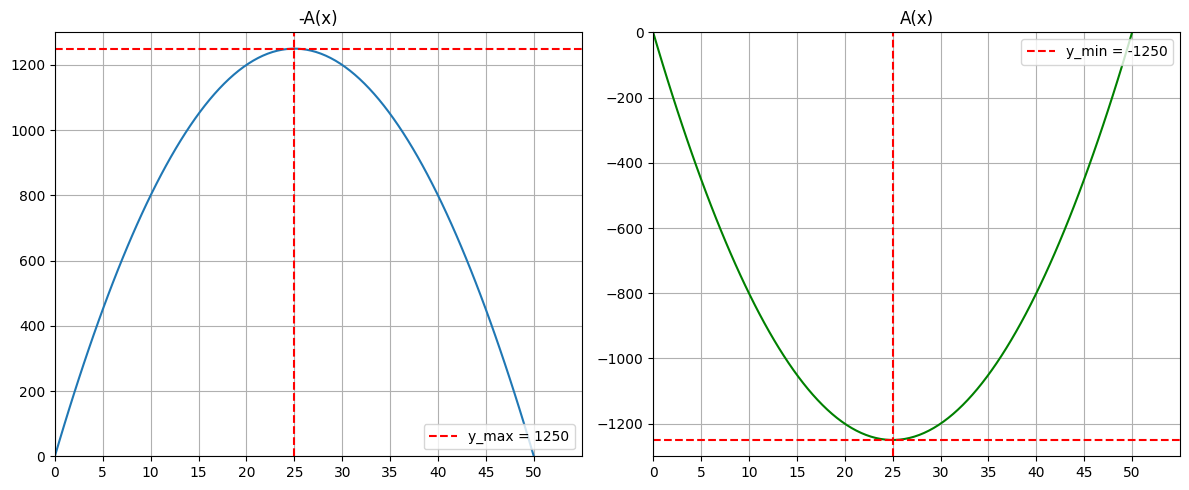

In [193]:
x = np.linspace(0, 50, 100)
y_1 = -2 * x**2 + 100 * x
y_2 = 2 * x**2 - 100 * x


max_y_index = np.argmax(y_1)
max_x = x[max_y_index]
max_y = y_1[max_y_index]

min_y_index = np.argmin(y_2)
min_x = x[min_y_index]
min_y = y_2[min_y_index]

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first graph
axs[0].plot(x, y_1)
axs[0].axhline(y=max_y, color='r', linestyle='--', label=f'y_max = {round(max_y)}')
axs[0].axvline(x=round(max_x), color='r', linestyle='--')
axs[0].set_ylim(0, 1300)
axs[0].set_xlim(0, 55)
axs[0].set_xticks(np.arange(0, 51, 5))
axs[0].grid()
axs[0].legend(loc='lower right')
axs[0].set_title('-A(x)')

# Plot the second graph
axs[1].plot(x, y_2, color='g')
axs[1].axhline(y=min_y, color='r', linestyle='--', label=f'y_min = {round(min_y)}')
axs[1].axvline(x=round(min_x), color='r', linestyle='--')
axs[1].set_ylim(-1300, 0)
axs[1].set_xlim(0, 55)
axs[1].set_xticks(np.arange(0, 51, 5))
axs[1].grid()
axs[1].legend(loc='upper right')
axs[1].set_title('A(x)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Conclusion

This tutorial has been a very gentle introduction into optimization specifically integer/continuous optimization with Dirac-3. If you want to start solving your own problems with this device then please see [Dirac-3 quick start](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/dirac-3-quick-start). If you want more details about the device itself, please see the [Dirac-3 product page](). For a much more in-depth understanding, please read our [recent preprint](https://arxiv.org/abs/2407.04512) about the device. For examples of different kinds of optimisation please try our tutorials on [quadratic unconstrianed binary optmization](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/qubo-on-dirac) and [quadratic linearly constrained binary optimization](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/qlcbo-on-dirac).